In [2]:
import os
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
BRICK = '015823m04663'
outdir = os.path.join(os.environ.get('SCRATCH'), 'SGA2024/bricks', BRICK)
outdir

'/pscratch/sd/i/ioannis/SGA2024/bricks/015823m04663'

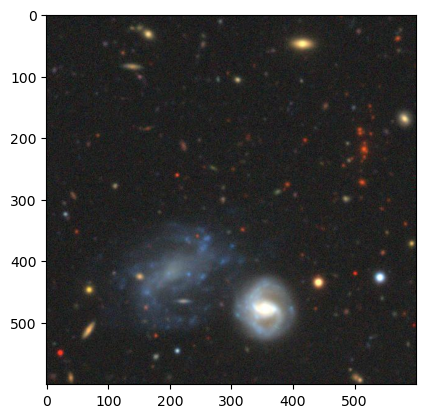

In [19]:
img = plt.imread(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image.jpg')
plt.imshow(img)

/tmp/ipykernel_1667825/1060232688.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(rimg), origin='lower')


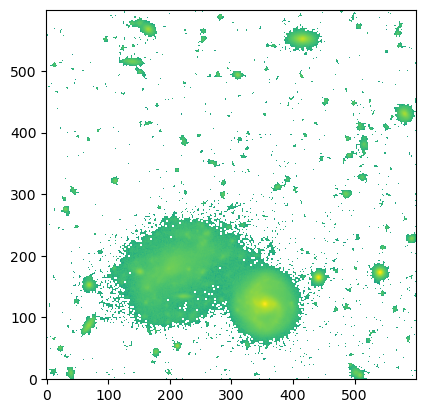

In [56]:
rimg = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image-r.fits.fz')
plt.imshow(np.log10(rimg), origin='lower')

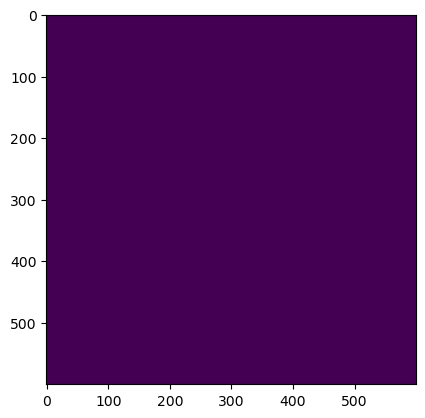

In [57]:
mask = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-maskbits.fits.fz')
plt.imshow(mask)

ra,dec,ref_cat,ref_id,mag,istycho,isgaia,islargegalaxy,iscluster,isbright,ismedium,freezeparams,pointsource,donotfit,in_bounds,ba,pa,decam_mag_g,decam_mag_r,decam_mag_i,decam_mag_z,zguess,mask_mag,radius,keep_radius,radius_pix,ibx,iby,ref_epoch,pmra,pmdec,parallax,ra_ivar,dec_ivar,pmra_ivar,pmdec_ivar,parallax_ivar,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_n_obs,astrometric_excess_noise,astrometric_excess_noise_sig,duplicated_source,phot_bp_rp_excess_factor,astrometric_sigma5d_max,astrometric_params_solved
float64,float64,str2,int64,float32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,bool,float32,float32,uint8
15.76005061630907,-4.8370552538073985,GE,2525049829240950144,5.0785265,True,True,False,False,True,True,False,True,False,False,0.0,0.0,5.8229094,4.924919,4.6499987,4.513409,4.513409,5.0785265,0.08319182,0.33276728,1144,1164,-2092,2016.0,-116.58516,-102.60755,9.508311,2494790300000000.0,5318064000000000.0,109.23901,124.45834,137.97176,5.0785265,5.6536,4.3491483,1713.1199,1504.7421,322.43893,262,0.48428303,282.0684,False,1.2510798,0.15741968,95
15.799815800991192,-4.629510667381685,GE,2525073159502950272,14.17785,False,True,False,False,False,True,False,True,False,False,0.0,0.0,14.513109,14.095784,13.988249,13.965939,13.965939,14.17785,0.0039968817,0.015987527,55,620,760,2016.0,7.932692,-0.66877645,1.2706335,2.4745145e+16,5.0897342e+16,1801.7802,1550.3191,1297.8739,14.17785,14.499743,13.684232,4717.419,1074.5609,979.2078,296,0.0,0.0,False,1.2023752,0.041104306,31
15.805552788266539,-4.672243895594406,GE,2525069998407021312,17.163004,False,True,False,False,False,False,False,True,False,True,0.0,0.0,17.680916,17.037405,16.851118,16.773243,16.773243,17.163004,0.0014764405,0.005905762,21,541,172,2016.0,13.739943,-0.9664553,0.4639768,2550276400000000.0,4566566000000000.0,136.58972,126.29753,137.9839,17.163004,17.610178,16.548634,1184.9962,98.96174,183.01787,321,0.118182756,0.42135018,False,1.2216384,0.14476044,31
15.812834082776737,-4.672837478567456,GE,2525069998407021696,17.495584,False,True,False,False,False,False,False,True,False,True,0.0,0.0,18.774326,17.416992,16.810377,16.531963,16.531963,17.495584,0.0013213865,0.005285546,19,441,164,2016.0,-4.850088,-11.788209,0.82817787,1791273300000000.0,3476503300000000.0,93.95486,88.71517,98.51978,17.495584,18.388046,16.544672,1064.6107,71.55858,206.26604,312,0.0,0.0,False,1.3293692,0.17274249,31
15.805174039902397,-4.688271570704278,GE,2525069753593641728,18.727879,False,True,False,False,False,False,False,False,False,False,0.0,0.0,19.04259,18.651926,18.554926,18.539263,18.539263,18.727879,0.00087596837,0.0035038735,13,546,-48,2016.0,11.617759,-12.772981,0.050704677,439187100000000.0,753778840000000.0,23.107977,20.548859,24.04258,18.727879,19.082396,18.29859,553.33746,43.44676,46.532948,321,0.2503391,0.3037982,False,1.1482627,0.3562025,31
15.8192010510771,-4.675963374402324,GE,2525069792248591616,19.056929,False,True,False,False,False,False,False,False,True,True,0.0,0.0,19.787436,18.904224,18.635036,18.501835,18.501835,19.056929,0.00078489917,0.0031395967,11,354,121,2016.0,0.0,0.0,0.0,13401133000000.0,36664995000000.0,0.0,0.0,0.0,19.056929,17.078438,15.78777,120.32316,87.003136,266.75903,269,6.113514,50.389194,False,13.034284,1.8050677,3
15.82954514259039,-4.680914116023231,GE,2525069723529202048,20.559723,False,True,False,False,False,False,False,False,False,True,0.0,0.0,20.996702,20.451025,20.297174,20.242922,20.242922,20.559723,0.00047542376,0.001901695,7,213,53,2016.0,1.1264869,-6.5655255,0.25716403,27198833000000.0,25693813000000.0,0.82009596,0.42566913,1.5238757,20.559723,20.826082,19.866005,116.60602,8.664745,11.721791,189,0.0,0.0,False,1.

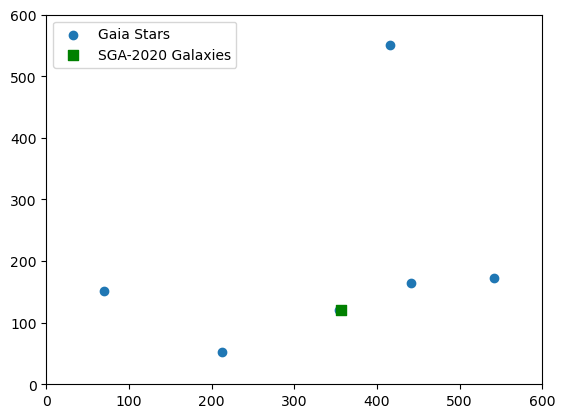

In [58]:
f'{outdir}/metrics/cus/reference-custom-{BRICK}.fits'
refs = Table(fitsio.read(f'{outdir}/metrics/cus/reference-custom-{BRICK}.fits'))
#plt.scatter(refs['ra'], refs['dec'])
plt.scatter(refs['ibx'], refs['iby'], label='Gaia Stars')
L3 = refs['ref_cat'] == 'L3'
if np.any(L3):
    plt.scatter(refs['ibx'][L3], refs['iby'][L3], s=50, marker='s', 
                color='green', label='SGA-2020 Galaxies')
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.legend()
refs
#img.shape

In [35]:
srcs = Table(fitsio.read(f'{outdir}/metrics/cus/sources-custom-{BRICK}.fits'))
blobarea = np.log10((srcs['blob_x1']-srcs['blob_x0']) * (srcs['blob_y1']-srcs['blob_y0']))
#blobarea = np.log10(1000 * np.ceil(blobarea / 1000))
#print(np.unique(blobarea))
srcs

ra,dec,ibx,iby,peaksn,fwhm,ref_cat,ref_id,isgalaxy,ba,astrometric_params_solved,decam_mag_g,freezeparams,donotfit,decam_mag_z,pa,pmra,kmag,radius,ggguess,astrometric_excess_noise_sig,source_id,phot_bp_mean_mag,pointsource,mag,ipd_gof_harmonic_amplitude,iscluster,isbright,dec_ivar,phot_bp_rp_excess_factor,ipd_frac_multi_peak,parallax,astrometric_sigma5d_max,istycho,phot_rp_mean_flux_over_error,pmdec,radius_pix,in_bounds,decam_mag_i,pmra_ivar,isgaia,pmdec_ivar,ref_epoch,phot_g_mean_mag,phot_rp_mean_mag,phot_g_n_obs,parallax_ivar,ra_ivar,zguess,ruwe,jmag,ismedium,phot_g_mean_flux_over_error,astrometric_excess_noise,phot_bp_mean_flux_over_error,duplicated_source,mask_mag,islargegalaxy,hmag,decam_mag_r,keep_radius,blob,blob_x0,blob_x1,blob_y0,blob_y1,flux_g,flux_r,flux_z
float64,float64,int64,int64,float32,float64,str2,int64,uint8,float32,uint8,float32,bool,bool,float32,float32,float32,float32,float32,float64,float32,int64,float32,bool,float32,float32,bool,bool,float32,float32,int8,float32,float32,bool,float32,float32,int64,bool,float32,float32,bool,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,bool,float32,float32,float32,bool,float32,bool,float32,float32,float32,int32,int64,int64,int64,int64,float64,float64,float64
15.802645299266151,-4.653502201950295,581,430,448.28333,8.0,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,31,433,600,281,484,4.974235534667969,12.294596672058105,21.83708381652832
15.843390403269664,-4.681157765590874,23,50,375.87463,5.656854249492381,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0,0,58,0,78,0.3688153922557831,1.521142840385437,18.47772979736328
15.83302084582923,-4.643531877278357,165,567,350.38123,8.0,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,65,81,193,459,600,3.4909849166870117,9.752273559570312,18.127975463867188
15.840031356860562,-4.678465076430798,69,87,289.6564,8.0,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,7,23,492,12,361,2.105687379837036,6.568272590637207,14.239303588867188
15.833970511069024,-4.672133528850042,152,174,194.65941,8.0,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,7,23,492,12,361,2.321716785430908,5.258481025695801,10.266009330749512
15.807974978850519,-4.684360112141195,508,6,142.67984,5.656854249492381,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,4,477,548,0,54,1.4927161931991577,3.8120131492614746,7.561107635498047
15.822360292981433,-4.648917499786501,311,493,131.38255,5.656854249492381,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,70,232,331,474,517,1.6588190793991089,4.0109028816223145,6.797451972961426
15.807464436828948,-4.657141214047816,515,380,124.85302,8.0,,0,0,0.0,0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,False,0.0,0.0,False,False,0.0,0.0,0,0.0,0.0,False,0.0,0.0,0,False,0.0,0.0,False,0.0

In [69]:
def qa(srcs, refsrcs=None, minfwhm=0.0, xc='ibx', yc='iby', maxscale=50):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))#, sharey=True)
    img = plt.imread(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image.jpg')
    ax[0].imshow(img)
    ax[1].imshow(img)

    if refsrcs:
        ax[1].scatter(refsrcs[xc], 600-refsrcs[yc], marker='+', color='cyan', s=150)#, facecolor='none')

    I = srcs['fwhm'] > minfwhm
    markerscale = maxscale * (srcs['fwhm'][I].data - minfwhm) / (np.max(srcs['fwhm'][I].data) - minfwhm)
    #print(sorted(set(markerscale)))
    for src, ms in zip(srcs[I], markerscale):
        ax[1].scatter(src[xc], 600-src[yc], marker='o', edgecolor='cyan', 
                      facecolor='none', s=ms)
    ax[0].set_ylim(600, 0)
    ax[1].set_ylim(600, 0)
    for xx in ax:
        xx.set_xlim(0, 600)
    fig.subplots_adjust(wspace=0.15)

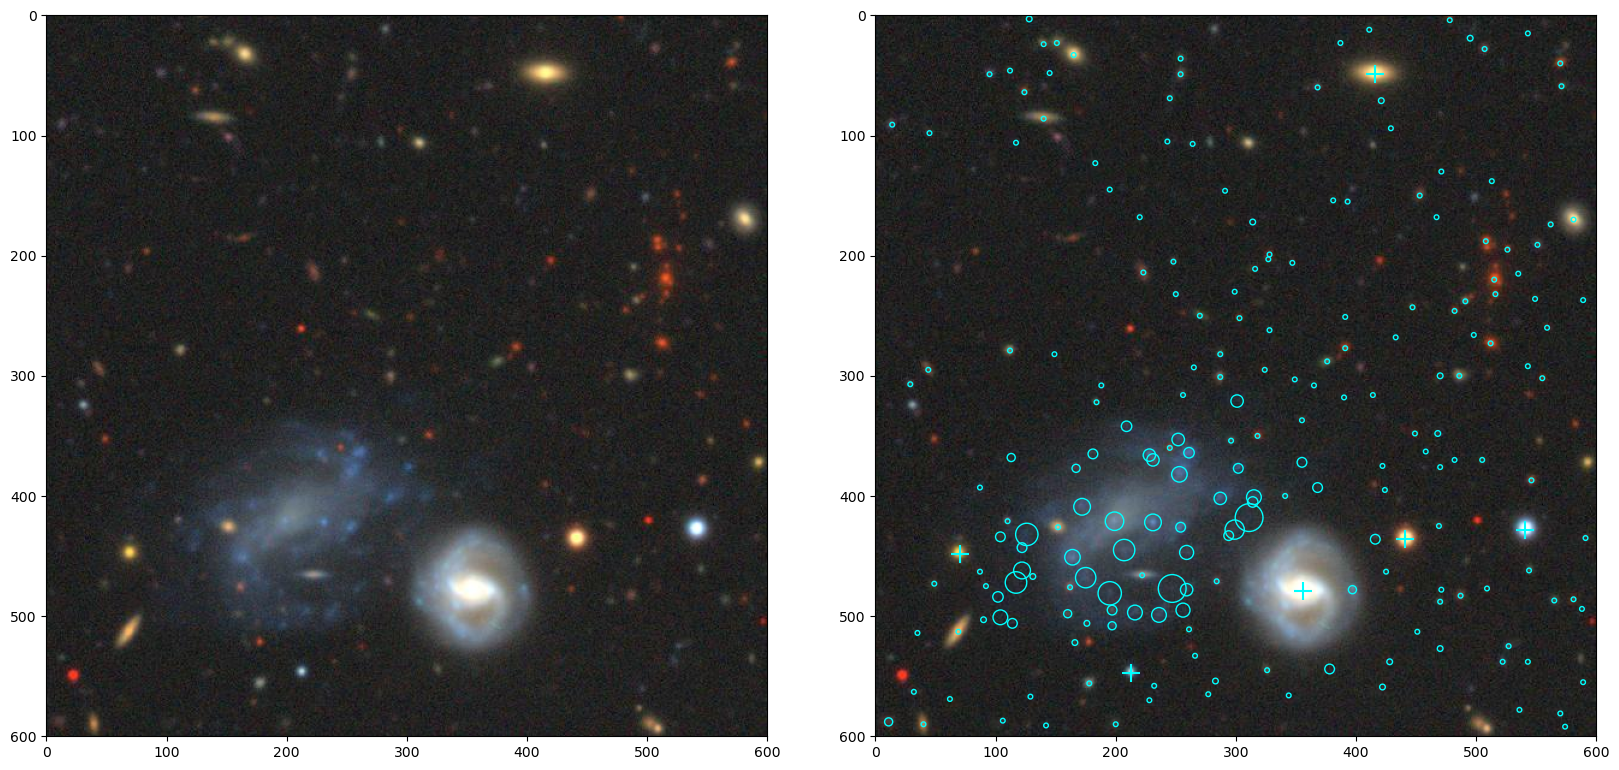

In [70]:
J = srcs['ref_cat'] != '  '
qa(srcs, refsrcs=srcs[J], minfwhm=7.0, xc='ibx', yc='iby', maxscale=400)

### Try photutils tools

In [29]:
from photutils.detection import StarFinder
from photutils.segmentation import make_2dgaussian_kernel

rimg = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image-r.fits.fz')
rivar = fitsio.read(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-invvar-r.fits.fz')
sig = 1 / np.median(np.sqrt(rivar))

In [32]:
kernel = make_2dgaussian_kernel(fwhm=5.0, size=15).array
starfind = StarFinder(threshold=10*sig, kernel=kernel, min_separation=5, exclude_border=True)
psrcs = starfind(rimg)
psrcs

id,xcentroid,ycentroid,fwhm,roundness,pa,max_value,flux,mag
int64,float64,float64,float64,float64,float64,float32,float32,float32
1,39.790066585391784,9.764311228727923,7.422643059702174,0.2850738756461201,96.87642594531228,0.06573804,3.6968298,-1.4195738
2,177.8991123654718,43.81870100222278,6.801881414889315,0.10154469754968719,52.22838126959144,0.07543259,3.2489395,-1.2793541
3,22.888562168055977,49.95608272022181,6.02378373766338,0.07757724779972167,69.83460042008332,0.06906288,1.713063,-0.5844333
4,212.62139643005602,53.32987946064663,5.448804520224175,0.022013975099107883,61.33633176088206,0.26630387,5.9672375,-1.9394333
5,68.904580790313,86.84829672992954,8.31331762136454,0.503697837110692,53.20512867509377,0.20660797,13.57984,-2.8322365
6,345.9643306176164,88.50290933452666,9.719999822250825,0.106693006397207,138.17007921405366,0.11877022,19.682564,-3.2352042
7,371.6376603101651,93.37988902231261,9.832334025346633,0.10190014295935712,49.54852441257826,0.10496779,16.426203,-3.038843
8,338.47262310583534,96.49881662929396,9.82561064746066,0.0872901052642429,126.16945612863515,0.13691886,22.016174,-3.3568547
9,341.7658883334445,109.33170456080482,9.741178406560575,0.1065275543374079,46.39026105949028,0.47426486,42.00787,-4.0583267


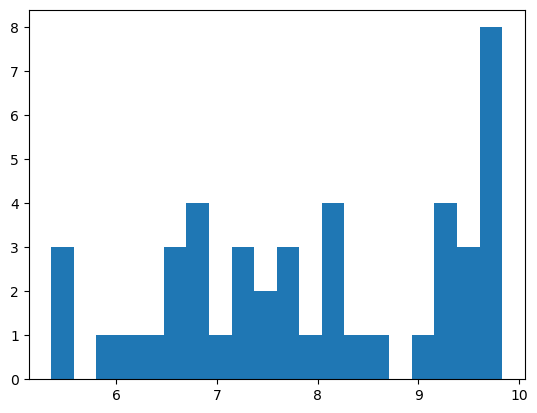

In [59]:
_ = plt.hist(psrcs['fwhm'], bins=20)

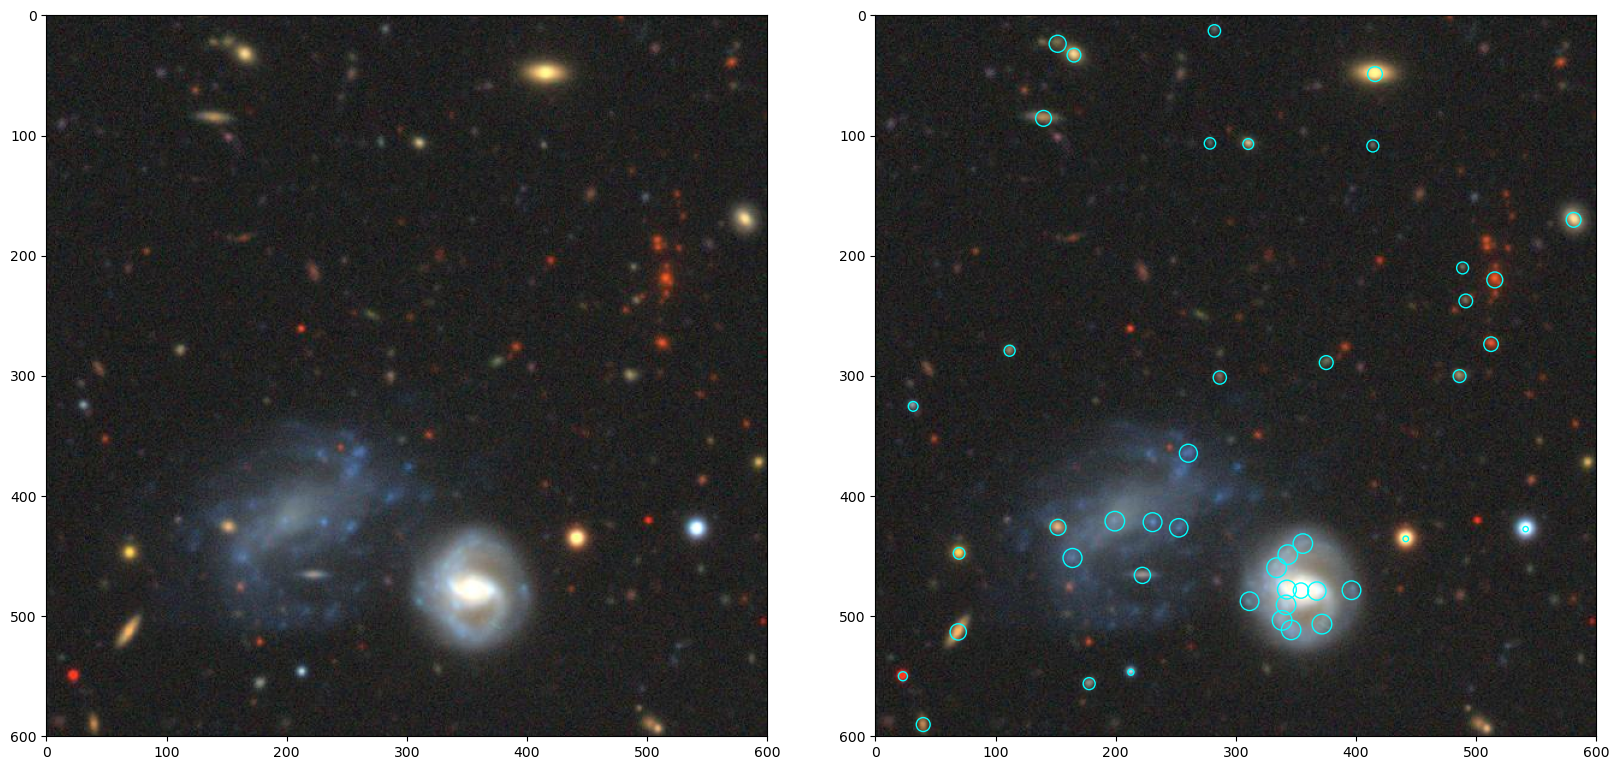

In [72]:
qa(psrcs, minfwhm=5, xc='xcentroid', yc='ycentroid', maxscale=200)

In [45]:
stop

NameError: name 'stop' is not defined

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))#, sharey=True)
img = plt.imread(f'{outdir}/coadd/cus/custom-{BRICK}/legacysurvey-custom-{BRICK}-image.jpg')
ax[0].imshow(img)
ax[1].imshow(img)
for src in srcs:
    ax[1].scatter(src['ibx'], 600-src['iby'], marker='+', color='dodgerblue')
#plt.scatter(srcs['ra'], srcs['dec'])
S = ax[2].scatter(srcs['ibx'], srcs['iby'], c=blobarea, cmap='gnuplot_r')
ax[0].set_ylim(600, 0)
ax[1].set_ylim(600, 0)
ax[2].set_ylim(0, 600)
for xx in ax:
    xx.set_xlim(0, 600)
plt.colorbar(S, label=r'$\log_{10}\,$(Blob Area) (pixels$^{2}$)')
fig.subplots_adjust(wspace=0.15)